In [19]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix

from yellowbrick.classifier import ROCAUC

from keras.utils.np_utils import to_categorical

from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

In [20]:
# Load all sklearn models
with open("./model/all_sklearn.pkl", "rb") as f:
    sklearn_models = pickle.load(f)

# Load all deep learning models
three_model = load_model("./model/3_layers.h5")
five_model = load_model("./model/5_layers.h5")
seven_model = load_model("./model/7_layers.h5")
sevenD_model = load_model("./model/7_layers_with_dropout.h5")

# Load input scaler
with open("./model/ki_input_scaler.pkl", "rb") as f:
    sc = pickle.load(f)

In [21]:
def describe_dataset(dataset_path: str):
    '''
    Describe dataset
    '''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {len(duplicate.sum(axis=1))}")

    return data


def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))

In [22]:
# load dataset
test_df = describe_dataset("./test.csv")

# Categorizing label
test_df.loc[test_df["label"] == "no_error", "label"] = 0
test_df.loc[test_df["label"] == "knees_inward_error", "label"] = 1

# Standard Scaling of features
test_x = test_df.drop("label", axis = 1)
test_x = pd.DataFrame(sc.transform(test_x))

test_y = test_df["label"].astype('int')

# # Converting prediction to categorical
test_y_cat = to_categorical(test_y)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v']
Number of rows: 3362 
Number of columns: 37

Labels: 
no_error              2905
knees_inward_error     457
Name: label, dtype: int64

Missing values: False

Duplicate Rows : 0


In [23]:
testset_final_results = []

for name, model in sklearn_models.items():
    # Evaluate model
    model_results = model.predict(test_x)

    p_score = precision_score(test_y, model_results, average="weighted")
    a_score = accuracy_score(test_y, model_results)
    r_score = recall_score(test_y, model_results, average="weighted")
    f1_score_result = f1_score(test_y, model_results, average="weighted")
    cm = confusion_matrix(test_y, model_results, labels=[0, 1, 2])
    testset_final_results.append(( name,  p_score, r_score, a_score, f1_score_result, cm ))


sklearn_eval = pd.DataFrame(testset_final_results, columns=["Model", "Precision Score", "Recall Score", "Accuracy Score", "F1 Score", "Confusion Matrix"])

sklearn_eval

,Model,Precision Score,Recall Score,Accuracy Score,F1 Score,Confusion Matrix
0,LR,0.829300,0.831945,0.831945,0.830598,"[[2631, 274, 0], [291, 166, 0], [0, 0, 0]]"
1,SVC,0.822090,0.844438,0.844438,0.831015,"[[2719, 186, 0], [337, 120, 0], [0, 0, 0]]"
2,KNN,0.798030,0.762641,0.762641,0.778511,"[[2415, 490, 0], [308, 149, 0], [0, 0, 0]]"
3,DTC,0.793153,0.743605,0.743605,0.765249,"[[2350, 555, 0], [307, 150, 0], [0, 0, 0]]"
4,SGDC,0.818675,0.856038,0.856038,0.828163,"[[2801, 104, 0], [380, 77, 0], [0, 0, 0]]"
5,NB,0.804432,0.693040,0.693040,0.734585,"[[2115, 790, 0], [242, 215, 0], [0, 0, 0]]"
6,RF,0.815163,0.851576,0.851576,0.826268,"[[2782, 123, 0], [376, 81, 0], [0, 0, 0]]"


In [24]:
test_set_results = []

model_paths = ["./model/3_layers.h5", 
               "./model/5_layers.h5", 
               "./model/7_layers.h5", 
               "./model/7_layers_with_dropout.h5"]

for path in model_paths:
    model = load_model(path)

    # Evaluate model
    predict_x = model.predict(test_x, verbose=False) 
    y_pred_class = np.argmax(predict_x, axis=1)
    y_test_class = np.argmax(test_y_cat, axis=1)

    cm = confusion_matrix(y_test_class, y_pred_class, labels=[0, 1, 2])
    p_score = precision_score(y_test_class, y_pred_class, average="weighted")
    a_score = accuracy_score(y_test_class, y_pred_class)
    r_score = recall_score(y_test_class, y_pred_class, average="weighted")
    f1_score_result = f1_score(y_test_class, y_pred_class, average="weighted")
    
    test_set_results.append(( path,  p_score, r_score, a_score, f1_score_result, cm ))

dp_eval = pd.DataFrame(test_set_results, columns=["Model Path", "Precision Score", "Recall Score", "Accuracy Score", "F1 Score", "Confusion Matrix"])

dp_eval

,Model Path,Precision Score,Recall Score,Accuracy Score,F1 Score,Confusion Matrix
0,./model/3_layers.h5,0.809437,0.781678,0.781678,0.794174,"[[2463, 442, 0], [292, 165, 0], [0, 0, 0]]"
1,./model/5_layers.h5,0.795888,0.776026,0.776026,0.785347,"[[2477, 428, 0], [325, 132, 0], [0, 0, 0]]"
2,./model/7_layers.h5,0.798234,0.773052,0.773052,0.784659,"[[2458, 447, 0], [316, 141, 0], [0, 0, 0]]"
3,./model/7_layers_with_dropout.h5,0.799332,0.792980,0.792980,0.796083,"[[2540, 365, 0], [331, 126, 0], [0, 0, 0]]"


In [25]:
eval_df = pd.concat([sklearn_eval, dp_eval])
eval_df = eval_df.sort_values(by=['F1 Score'], ascending=False).reset_index(drop=True)
eval_df.to_csv(f"evaluation.csv", sep=',', encoding='utf-8', index=False)
eval_df

,Model,Precision Score,Recall Score,Accuracy Score,F1 Score,Confusion Matrix,Model Path
0,SVC,0.822090,0.844438,0.844438,0.831015,"[[2719, 186, 0], [337, 120, 0], [0, 0, 0]]",NaN
1,LR,0.829300,0.831945,0.831945,0.830598,"[[2631, 274, 0], [291, 166, 0], [0, 0, 0]]",NaN
2,SGDC,0.818675,0.856038,0.856038,0.828163,"[[2801, 104, 0], [380, 77, 0], [0, 0, 0]]",NaN
3,RF,0.815163,0.851576,0.851576,0.826268,"[[2782, 123, 0], [376, 81, 0], [0, 0, 0]]",NaN
4,NaN,0.799332,0.792980,0.792980,0.796083,"[[2540, 365, 0], [331, 126, 0], [0, 0, 0]]",./model/7_layers_with_dropout.h5
5,NaN,0.809437,0.781678,0.781678,0.794174,"[[2463, 442, 0], [292, 165, 0], [0, 0, 0]]",./model/3_layers.h5
6,NaN,0.795888,0.776026,0.776026,0.785347,"[[2477, 428, 0], [325, 132, 0], [0, 0, 0]]",./model/5_layers.h5
7,NaN,0.798234,0.773052,0.773052,0.784659,"[[2458, 447, 0], [316, 141, 0], [0, 0, 0]]",./model/7_layers.h5
8,KNN,0.798030,0.762641,0.762641,0.778511,"[[2415, 490, 0], [308, 149, 0], [0, 0, 0]]",NaN
9,DTC,0.793153,0.743605,0.743605,0.765249,"[[2350, 555, 0], [307, 150, 0], [0, 0, 0]]",NaN


In [26]:
best_model = sklearn_models["SVC"]
y_predictions = best_model.predict(test_x)

p_score = precision_score(test_y, y_predictions, labels=[0, 1], average=None)
r_score = recall_score(test_y, y_predictions, labels=[0, 1], average=None)
f1_score_result = f1_score(test_y, y_predictions, labels=[0, 1], average=None)

p_score, r_score, f1_score_result

(array([0.88972513, 0.39215686]),
 array([0.93597246, 0.26258206]),
 array([0.91226304, 0.31454784]))

In [27]:
best_model01 = sevenD_model
y_predictions = best_model01.predict(test_x)

# convert continuous values to discrete labels using a threshold of 0.5
y_predictions_labels = (y_predictions >= 0.5).argmax(axis=-1)

p_score = precision_score(test_y, y_predictions_labels, labels=[0, 1], average=None)
r_score = recall_score(test_y, y_predictions_labels, labels=[0, 1], average=None)
f1_score_result = f1_score(test_y, y_predictions_labels, labels=[0, 1], average=None)

p_score, r_score, f1_score_result

106/106 [==============================] - 1s 3ms/step


(array([0.88470916, 0.25661914]),
 array([0.87435456, 0.27571116]),
 array([0.87950139, 0.26582278]))

In [28]:
(0.879 + 0.265) / 2

0.5720000000000001

<AxesSubplot:>

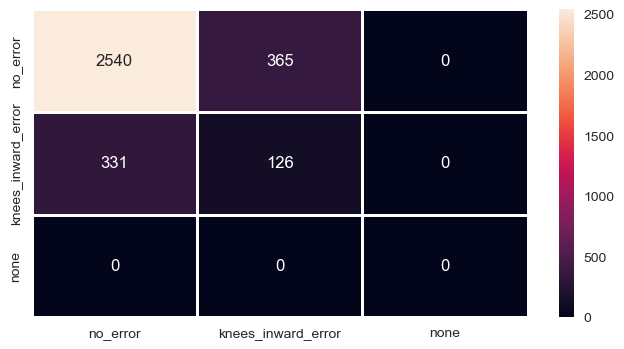

In [29]:
SVC_cm = eval_df[ eval_df["Model Path"] == './model/7_layers_with_dropout.h5' ]["Confusion Matrix"].values[0]

cm_array_df = pd.DataFrame(SVC_cm, index=["no_error", "knees_inward_error", "none"], columns=["no_error", "knees_inward_error", "none"])

fig, ax = plt.subplots(figsize=(8,4)) 
sns.heatmap(cm_array_df, linewidths=1, annot=True, ax=ax, fmt='g')

In [30]:
def to_labels(y_pred, y_pred_proba, threshold):
    '''Return prediction taking confidence threshold into account'''
    results = []

    for index, predicted_class in enumerate(y_pred):
        prediction_probabilities = y_pred_proba[index]
        class_prediction_probability = round(prediction_probabilities[np.argmax(prediction_probabilities)], 2)

        results.append(predicted_class if class_prediction_probability >= threshold else -1)
    
    return results


def calculate_correlation_score_confidence(test_x, test_y):
    '''Calculate correlation between Precision score/Recall score/F1 score and confidence threshold'''
    y_predictions = best_model01.predict(test_x)
    y_predict_logits = y_predictions
    y_predict_proba = tf.nn.softmax(y_predictions)

    thresholds = list(np.arange(0, 1.01, 0.01))
    f1_scores = []
    for threshold in thresholds:
        y_pred_bin = (y_predict_proba[:,1] > threshold).numpy().astype(int)
        f1 = f1_score(test_y, y_pred_bin, average=None)
        f1_scores.append(f1)

    return thresholds, f1_scores

106/106 [==============================] - 0s 3ms/step


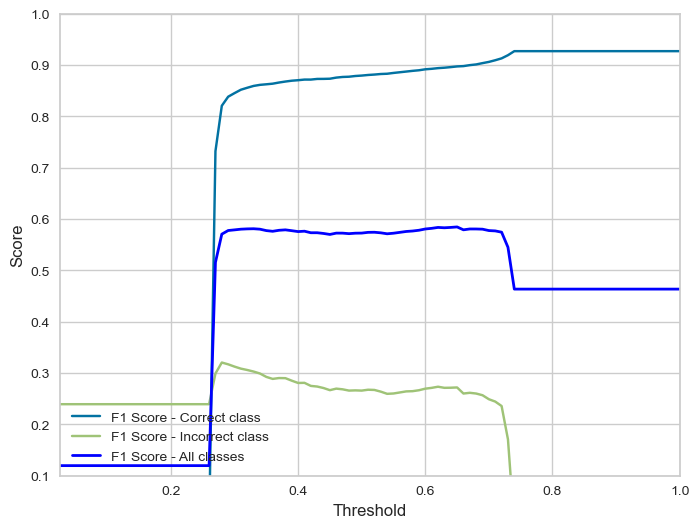

In [31]:
thresholds, f1_scores = calculate_correlation_score_confidence(test_x, test_y)

first_class = [ el[0] for el in f1_scores ]
second_class = [ el[1] for el in f1_scores ]
all_classes = [(el[0] + el[1]) / 2 for el in f1_scores]

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(thresholds, first_class, label = "F1 Score - Correct class")
plt.plot(thresholds, second_class, label = "F1 Score - Incorrect class")
plt.plot(thresholds, all_classes, label = "F1 Score - All classes", linewidth=2.0, color="blue")
plt.legend(loc = 'lower left')
plt.ylim([0.1, 1])
plt.xlim([0.025, 1])
plt.xlabel("Threshold", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
# plt.axvline(thresholds[np.argmin(abs(precision-recall))], color="k", ls = "--")
# plt.title(label = F"Threshold = {thresholds[np.argmin(abs(precision-recall))]:.3f}", fontsize = 12)
plt.show()

106/106 [==============================] - 0s 2ms/step
Optimal Threshold: 0.025321567431092262


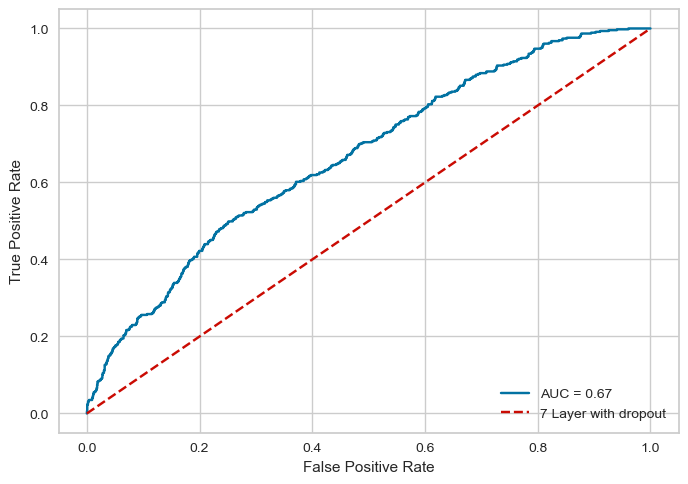

In [34]:
# calculate the fpr and tpr for all thresholds of the classification
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
probs = best_model01.predict(test_x)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

# method I: plt
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--', label="7 Layer with dropout")
plt.legend(loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()